<a href="https://colab.research.google.com/github/losirlu1411/project-/blob/main/tuberculosis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Data directory
data_dir = '/content/drive/MyDrive/project /TB_Chest_Radiography_Database'

# Image dimensions
img_height, img_width = 224, 224

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',)


# Define separate validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
)

# Base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # One unit for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)



Found 4210 images belonging to 2 classes.
Found 4210 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


132/132 ━━━━━━━━━━━━━━━━━━━━ 508s 4s/step - accuracy: 0.8528 - loss: 0.3573 - val_accuracy: 0.9344 - val_loss: 0.1594
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.9331 - loss: 0.1710 - val_accuracy: 0.9651 - val_loss: 0.1008
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9559 - loss: 0.1314 - val_accuracy: 0.9582 - val_loss: 0.0992
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9606 - loss: 0.1069 - val_accuracy: 0.9648 - val_loss: 0.0873
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9592 - loss: 0.1116 - val_accuracy: 0.9793 - val_loss: 0.0615
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.9729 - loss: 0.0910 - val_accuracy: 0.9660 - val_loss: 0.0859
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9748 - loss: 0.0850 - val_accuracy: 0.9874 - val_loss: 0.0485
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9748 - loss: 0.0793 - val_accuracy: 0.964

In [2]:
import matplotlib.pyplot as plt
import numpy as np

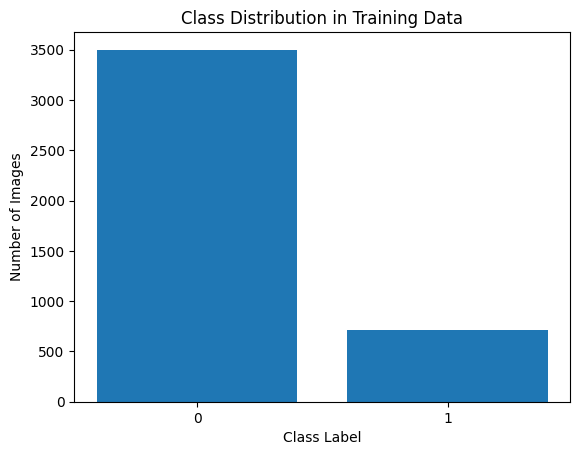

In [3]:
# Get class labels from the training data generator
class_labels = train_generator.classes

# Get the number of images in each class
class_counts = np.bincount(class_labels)

# Get unique class labels
unique_labels = np.unique(class_labels)  # This will give you [0, 1]

# Create the bar plot using unique labels and corresponding counts
plt.bar(unique_labels, class_counts) # Plot bars for each unique label
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Data")
plt.xticks(unique_labels) # Set x-axis ticks to match the unique labels
plt.show()


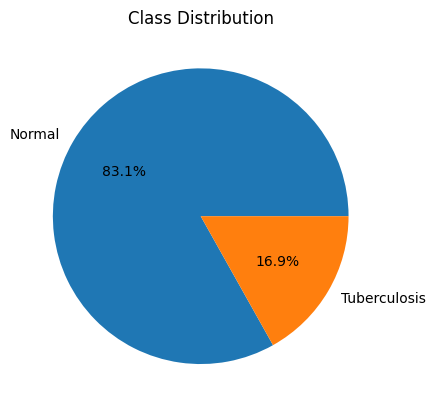

In [4]:
# Assuming you have a list of class labels and their corresponding counts
class_labels = ['Normal', 'Tuberculosis']

# Get the number of images in each class from the training generator
import numpy as np  # Make sure numpy is imported

class_labels_from_generator = train_generator.classes
class_counts = np.bincount(class_labels_from_generator)

# Alternatively, if you know the counts:
# class_counts = [3500, 700]  # Replace with actual counts

# Create the pie chart
import matplotlib.pyplot as plt  # Make sure matplotlib is imported

plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

In [5]:
 #saving the class names

class_names = train_generator.class_indices # Get class names from train_generator

print(f"The Class Names in the Dataset are:\n{class_names}")

The Class Names in the Dataset are:
{'Normal': 0, 'Tuberculosis': 1}


In [6]:
# storing number classes in the dataset
num_classes = len(train_generator.class_indices)
print(f"The Number of Classes in the Dataset are: {num_classes}")

The Number of Classes in the Dataset are: 2


In [ ]:
def track_batch_sizes(generator):
  batch_sizes = []
  for images, labels in generator:
    batch_sizes.append(images.shape[0])  # Get number of images in current batch
  return batch_sizes
  # Track batch sizes in training data
train_batch_sizes = track_batch_sizes(train_generator)

# Plot the histogram of batch sizes
plt.hist(train_batch_sizes)
plt.xlabel("Batch Size")
plt.ylabel("Frequency")
plt.title("Distribution of Batch Sizes in Training Data")
plt.show()